# Experiment 1

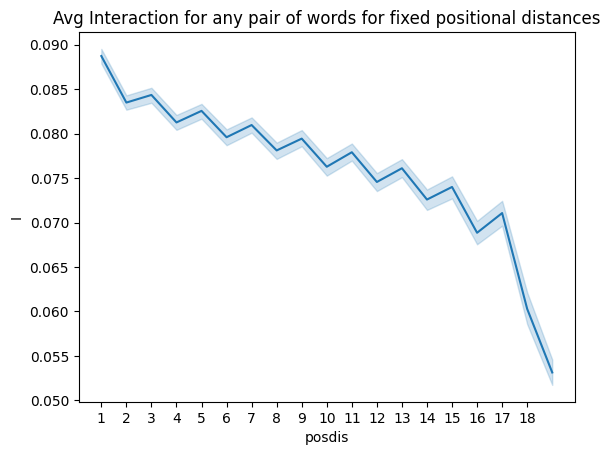

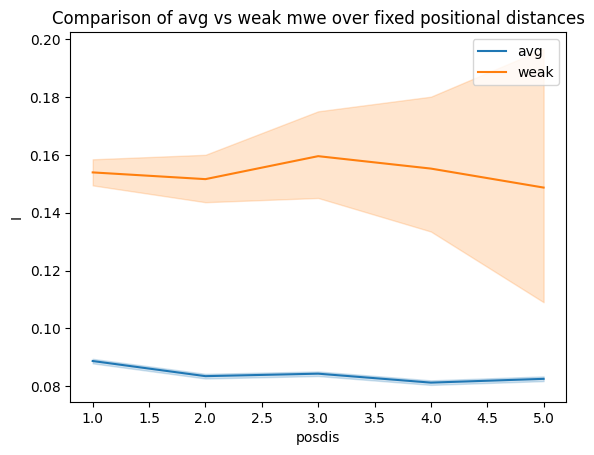

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean(avg_path='average_distance.pkl', weak_path='weak_mwe_distance.pkl', strong_path='strong_mwe_distance.pkl'):
    avg_dist = pd.read_pickle(avg_path)
    avg_df = pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore'])
    avg_df['posdis'] = avg_df['posdis'].astype(int)
    g = sns.lineplot(data=avg_df, x="posdis", y="I")
    g.set_title('Avg Interaction for any pair of words for fixed positional distances')
    g.set(xticks=list(range(1,19)))
    plt.show()
    weak_mwe_distance = pd.read_pickle(weak_path)
    weak_mwe_df = pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    weak_mwe_df = weak_mwe_df[weak_mwe_df['posdis']!=0].copy()
    weak_mwe_df['count'] = weak_mwe_df.groupby('posdis')['I'].transform(lambda x : x.count())
    weak_mwe_df = weak_mwe_df[weak_mwe_df['count']>=50].copy()
    weak_mwe_df['posdis'] = weak_mwe_df['posdis'].astype(int)
    avg_df = avg_df[avg_df['posdis']<=weak_mwe_df['posdis'].max()].copy()

    fig, ax = plt.subplots()
    avg_line = sns.lineplot(data=avg_df, x="posdis", y="I", ax=ax, label='avg')
    weak_line = sns.lineplot(data=weak_mwe_df, x="posdis", y="I", ax=ax, label='weak')
    ax.set_title('Comparison of avg vs weak mwe over fixed positional distances')
    ax.legend()
    # ax.legend(labels=['avg','weak'])
    
    g.set(xticks=list(range(1,6)))
    # strong_mwe_distance = pd.read_pickle(strong_path)
    # strong_mwe_df = pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    # strong_mwe_df['count'] = strong_mwe_df.groupby('posdis')['I'].count()
    # strong_mwe_df = strong_mwe_df[strong_mwe_df['count']>=50].copy()
    plt.show()
plot_mean()

# Experiment 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def f_df(path, method):
    abc = pd.read_pickle(path, compression='gzip')
    abc = abc.explode('tensor')
    abc[['method', 'tensor', 'token_next']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start'])
    
    abc['first_token'] = abc.apply(lambda x : x['ignore'][x['first_token']]-1, axis=1)
    abc['second_token'] = abc.apply(lambda x : x['ignore'][x['second_token']]-1, axis=1)
    
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    
    
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc

def f_avg_df(path, method):
    import pickle
    abc = pickle.load(open(path,'rb'))
    abc = pd.DataFrame(abc, columns = ['tensor', 'posdis', 'row_number', 'first_token', 'second_token'])
    abc = abc[abc['posdis']<=7].copy()
    abc = abc.explode('tensor')
    abc[['method', 'tensor', 'token_next']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start'])
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc

def plot(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(2, 4, figsize=(30,10))
    
    for i in range(0, 4):
        for j in [0,1]:
            min_dist = j*4 + i + 1
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
            # axes[j][i].set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
            axes[j][i].set_title(f'prediction token distance from furthest mwe token = {min_dist}')
            axes[j][i].legend()
    plt.show()
            

In [3]:
version = 100
load_avg = True
method = 4


In [4]:

weak_path = f'weak_mwe_gpt{version}.pkl'
weak_df = f_df(weak_path, method).drop(columns = ['ignore'])
weak_df = weak_df[weak_df['rem'] >= 50].copy()
display(weak_df)

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,1.351472,1,2,24,23,4,25,25,24,1,112781.0
1,1.221206,1,2,24,23,4,25,26,24,2,112574.0
2,1.216758,1,2,24,23,4,25,27,24,3,111813.0
3,1.133672,1,2,24,23,4,25,28,24,4,110268.0
4,0.334953,1,2,24,23,4,25,29,24,5,107987.0
...,...,...,...,...,...,...,...,...,...,...,...
2748760,1.084762,1,104014,4,3,4,5,5,4,1,112781.0
2748761,1.037443,1,104014,4,3,4,5,6,4,2,112574.0
2748762,0.397114,1,104014,4,3,4,5,7,4,3,111813.0
2748763,1.265175,1,104014,4,3,4,5,8,4,4,110268.0


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,1.614803,1,205,15,14,4,16,16,15,1,1531
1,1.012944,1,205,15,14,4,16,17,15,2,1530
2,0.668576,1,205,15,14,4,16,18,15,3,1525
3,0.704188,1,205,15,14,4,16,19,15,4,1513
4,2.243849,1,205,15,14,4,16,20,15,5,1478
...,...,...,...,...,...,...,...,...,...,...,...
48815,2.256932,1,103812,38,37,4,39,45,38,7,1415
48816,1.483732,1,103812,38,37,4,39,46,38,8,1369
48817,1.022018,1,103812,38,37,4,39,47,38,9,1309
48818,1.001193,1,103812,38,37,4,39,48,38,10,1250


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,0.335287,1,2,1,2,4,3,3,2,1,48174.0
1,1.080749,1,2,1,2,4,3,4,2,2,48172.0
2,1.356842,1,2,1,2,4,3,5,2,3,48165.0
3,0.842495,1,2,1,2,4,3,6,2,4,48136.0
4,1.857224,1,2,1,2,4,3,7,2,5,48077.0
...,...,...,...,...,...,...,...,...,...,...,...
7649563,0.997369,7,104000,7,14,4,15,33,14,19,26385.0
7649564,0.994536,7,104000,7,14,4,15,34,14,20,25005.0
7649565,0.843956,7,104000,7,14,4,15,35,14,21,23602.0
7649566,0.443599,7,104000,7,14,4,15,36,14,22,21771.0


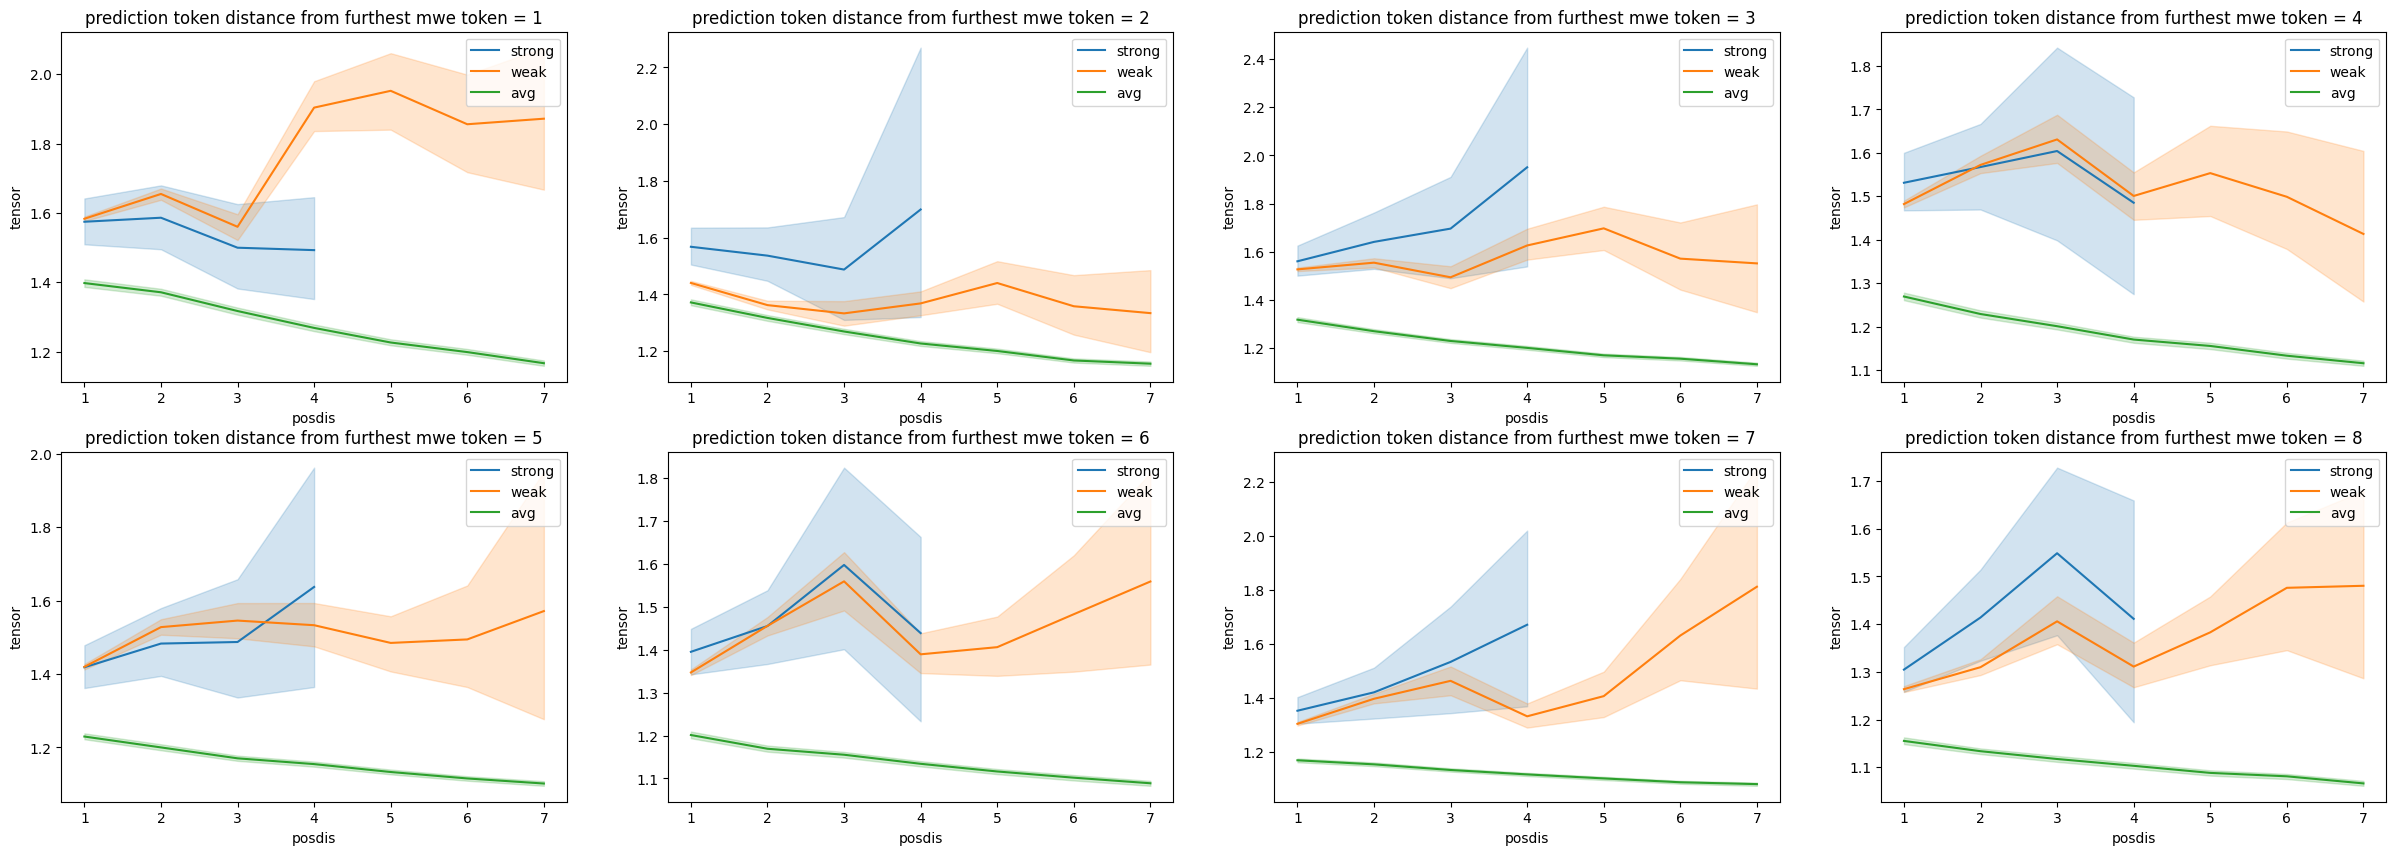

In [5]:
if load_avg:
    strong_path = f'strong_mwe_gpt{version}.pkl'
    strong_df = f_df(strong_path, method).drop(columns = ['ignore'])
    strong_df = strong_df[strong_df['rem'] >= 50].copy()
    display(strong_df)
    
    avg_df = f_avg_df(f'avg_gpt{version}.pkl', method)
    avg_df = avg_df[avg_df['rem'] >= 50].copy()
    display(avg_df)



if load_avg:
    plot(strong_df, weak_df, avg_df)

    # del strong_df, weak_df, avg_df
    

In [6]:
import pandas as pd
ap = []
for i in [0, 1, 2, 3]:
    print(i)
    abc = pd.read_pickle(f'../mwe_tagger/gpt_gpt.pkl_{i}').drop(columns = ['sentence', 'd', 'toks', 'tags', '_', '~', 'lemmas', 'tokens', 'sent',
       'syntactic_distance_idx', 'tokens_to_map', 'token_map', 'token_map_dict', 'weak_mwe', 'strong_mwe'])
    def foo(x):
        g = {}
        for tup, val in x.items():
            if len(tup) == 2: 
                for a in tup[0]:
                    for b in tup[1]:
                        g[(a, b)] = val
        return g
    abc['syntactic_distance_idx_mapped'] = abc['syntactic_distance_idx_mapped'].apply(foo)
    ab = abc.reset_index().rename(columns = {'index':'row_number'})
    ap.append(weak_df.merge(ab[['row_number', 'syntactic_distance_idx_mapped']], on = ['row_number']))


ap = pd.concat(ap)
ap['syntactic_distance_idx_mapped'] = ap[['syntactic_distance_idx_mapped', 'first_token', 'second_token']].apply(lambda x : x['syntactic_distance_idx_mapped'].get((x['first_token'], x['second_token']), -100), axis=1)

0
1
2
3


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


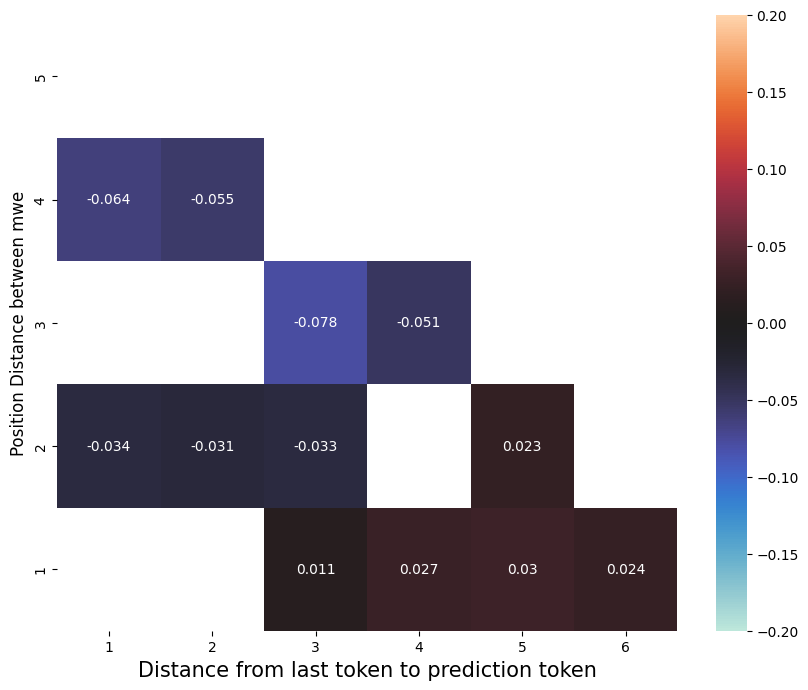

In [7]:
import numpy as np
zp = ap.copy()
zp['ct'] = zp.groupby(['posdis', 'min_dist', 'syntactic_distance_idx_mapped'])['tensor'].transform(lambda x : x.count())
zp = zp[zp['ct']>50]
zp = zp[zp['syntactic_distance_idx_mapped']>0]
zp = zp[zp['syntactic_distance_idx_mapped']<=6]
zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.min())
zp = zp[zp['diff_syn']==1]
# zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.nunique())
# zp = zp[zp['diff_syn']>=3]



from scipy.stats import pearsonr, spearmanr
# z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[0])
# y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[1])

z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[0])
y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[1])


y = y['syntactic_distance_idx_mapped'].reset_index()
y = y[y['level_2'] == 'tensor']
mask_apq = y[y['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
mask_apq.columns = [x[1] for x in mask_apq.columns]
mask_apq = mask_apq[::-1]
mask_apq = np.where(mask_apq > 0.05, np.nan, 1)


z = z['syntactic_distance_idx_mapped'].reset_index()
z = z[z['level_2'] == 'tensor']
apq = z[z['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
apq.columns = [x[1] for x in apq.columns]
apq = apq[::-1]
apq = apq * mask_apq


plt.figure(figsize=(10,8))

ax = sns.heatmap(apq, annot=True, center=0, vmin= -0.2, vmax=0.2)
plt.xlabel('Distance from last token to prediction token', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Position Distance between mwe', fontsize = 12) # y-axis label with fontsize 15

plt.show()

# Experiment 3

In [8]:
def plot_mlm(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(4, 4, figsize=(30,20))
    
    for i in range(0, 4):
        for j in range(4):
            min_dist = j*4 + i + 1 - 8
            
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
    
            # axes[j][i].set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
            axes[j][i].set_title(f'prediction token distance from furthest mwe token = {min_dist}')
            axes[j][i].legend()
    plt.show()        

In [9]:
version = 100
load_avg = True
method = 4
model = 'bert'


    
weak_path = f'weak_mwe_{model}{version}.pkl'
weak_df = f_df(weak_path, method).drop(columns = ['ignore'])
weak_df = weak_df[weak_df['rem'] >= 50].copy()
display(weak_df)

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,0.784911,1,2,30,29,4,0,0,30,-30,19022
1,1.245712,1,2,30,29,4,0,1,30,-29,21043
2,0.741942,1,2,30,29,4,0,2,30,-28,23124
3,1.002509,1,2,30,29,4,0,3,30,-27,25317
4,0.999524,1,2,30,29,4,0,4,30,-26,27643
...,...,...,...,...,...,...,...,...,...,...,...
6344319,0.315121,1,104014,4,3,4,0,6,4,2,127574
6344320,0.999770,1,104014,4,3,4,0,7,4,3,127124
6344321,0.999884,1,104014,4,3,4,0,8,4,4,126505
6344322,0.992830,1,104014,4,3,4,0,9,4,5,122489


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,0.923950,1,205,16,15,4,0,0,16,-16,748
1,0.753903,1,205,16,15,4,0,1,16,-15,793
2,1.000001,1,205,16,15,4,0,2,16,-14,846
3,0.999799,1,205,16,15,4,0,3,16,-13,909
4,1.002367,1,205,16,15,4,0,4,16,-12,966
...,...,...,...,...,...,...,...,...,...,...,...
105546,0.859763,1,103805,14,13,4,0,27,14,13,1127
105547,1.004100,1,103805,14,13,4,0,28,14,14,1072
105548,1.003667,1,103805,14,13,4,0,29,14,15,1014
105549,0.999977,1,103805,14,13,4,0,30,14,16,960


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,0.968527,1,2,1,2,4,0,0,2,-2,46090
1,1.005489,1,2,1,2,4,0,3,2,1,49026
2,0.999234,1,2,1,2,4,0,4,2,2,49026
3,1.000003,1,2,1,2,4,0,5,2,3,49024
4,0.998847,1,2,1,2,4,0,6,2,4,49018
...,...,...,...,...,...,...,...,...,...,...,...
11290220,0.999657,4,104000,17,21,4,0,34,21,13,40363
11290221,1.011568,4,104000,17,21,4,0,35,21,14,39327
11290222,1.000000,4,104000,17,21,4,0,36,21,15,38092
11290223,1.000002,4,104000,17,21,4,0,37,21,16,36809


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


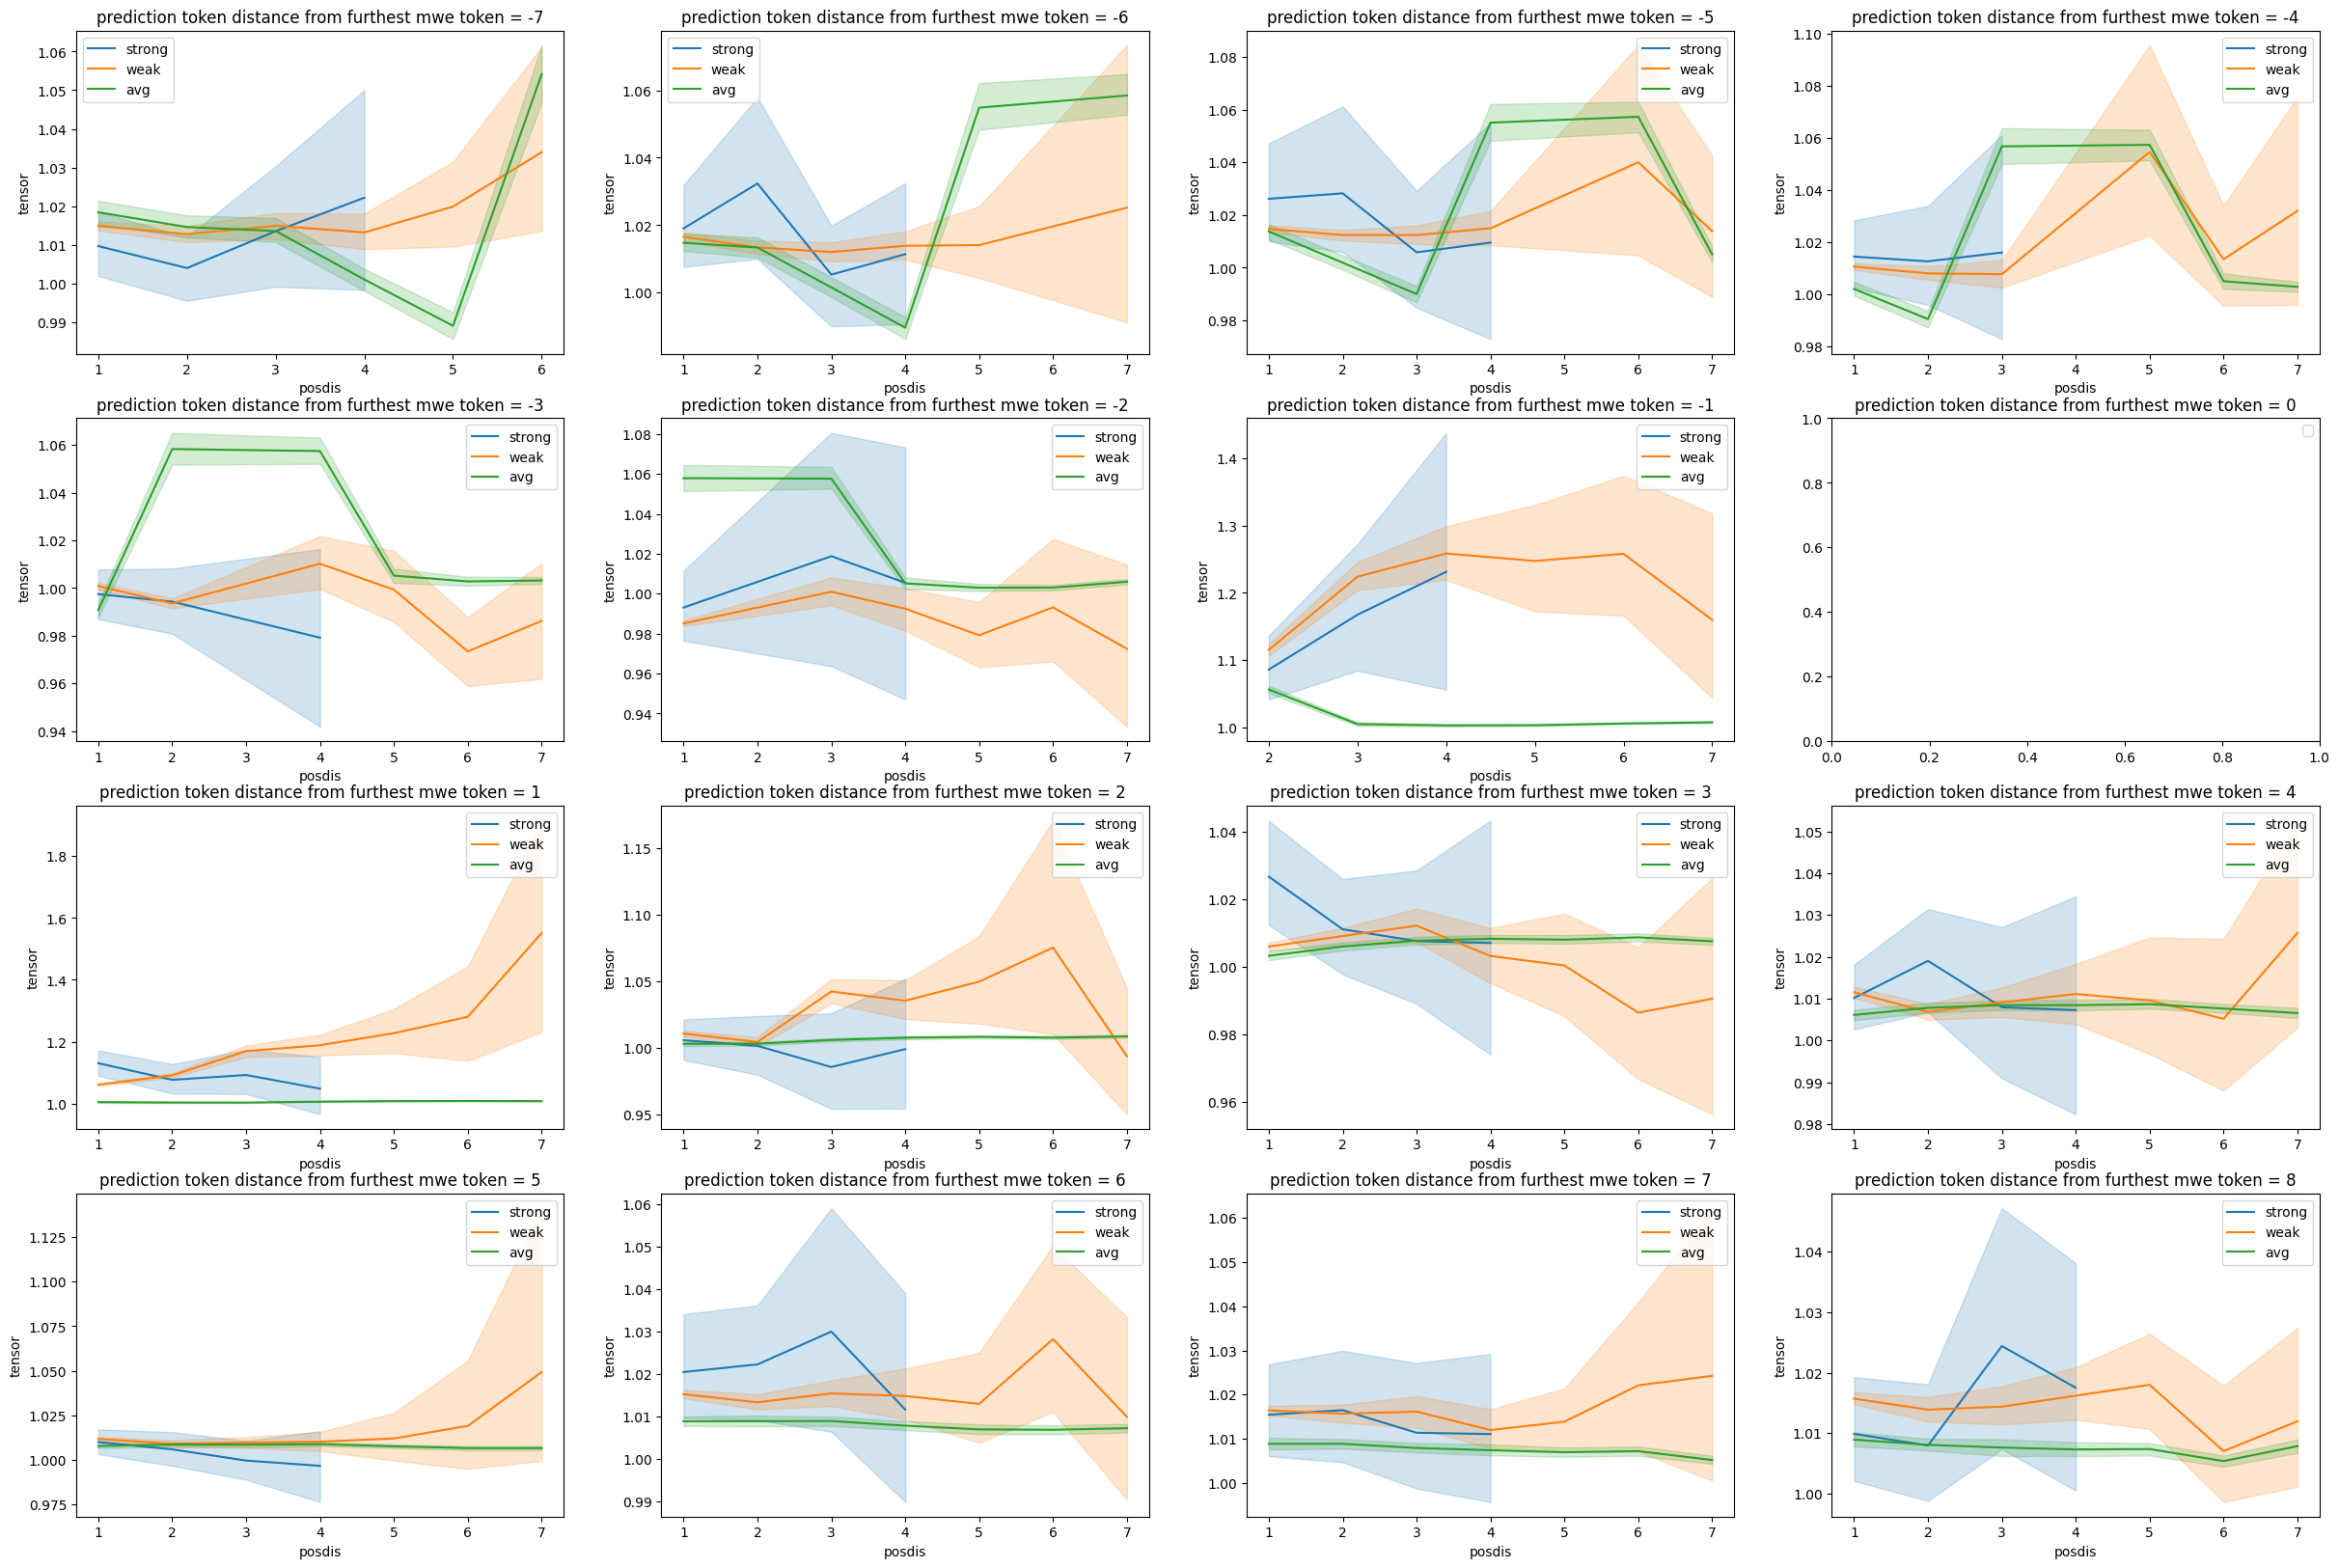

In [10]:
if load_avg:
    strong_path = f'strong_mwe_{model}{version}.pkl'
    strong_df = f_df(strong_path, method).drop(columns = ['ignore'])
    strong_df = strong_df[strong_df['rem'] >= 50].copy()
    display(strong_df)
    
    avg_df = f_avg_df(f'avg_{model}{version}.pkl', method)
    avg_df = avg_df[avg_df['rem'] >= 50].copy()
    display(avg_df)



if load_avg:
    plot_mlm(strong_df, weak_df, avg_df)

    # del strong_df, weak_df, avg_df

In [11]:
import pandas as pd
ap = []
for i in [0, 1, 2, 3]:
    abc = pd.read_pickle(f'../mwe_tagger/bert_bert.pkl_{i}')
    ab = abc.reset_index().rename(columns = {'index':'row_number'})
    ap.append(weak_df.merge(ab[['row_number', 'syntactic_distance_idx_mapped']], on = ['row_number']))

ap = pd.concat(ap)
ap['syntactic_distance_idx_mapped'] = ap[['syntactic_distance_idx_mapped', 'first_token', 'second_token']].apply(lambda x : x['syntactic_distance_idx_mapped'].get((x['first_token'], x['second_token']), -100), axis=1)

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


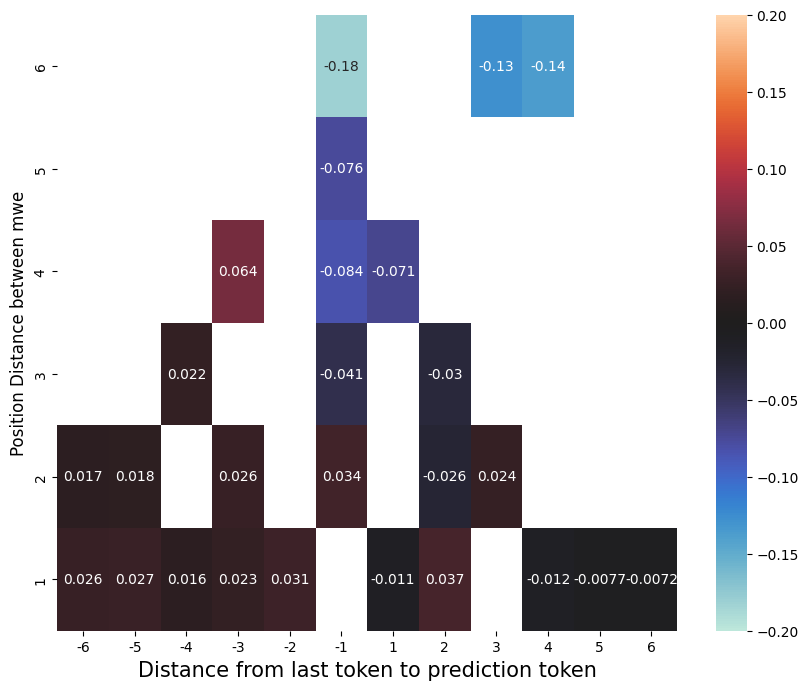

In [12]:
import numpy as np
zp = ap.copy()
zp['ct'] = zp.groupby(['posdis', 'min_dist', 'syntactic_distance_idx_mapped'])['tensor'].transform(lambda x : x.count())
zp = zp[zp['ct']>50]
zp = zp[zp['syntactic_distance_idx_mapped']>0]
zp = zp[zp['syntactic_distance_idx_mapped']<=6]
zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.min())
zp = zp[zp['diff_syn']==1]
# zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.nunique())
# zp = zp[zp['diff_syn']>=3]



from scipy.stats import pearsonr, spearmanr
# z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[0])
# y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[1])

z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[0])
y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[1])


y = y['syntactic_distance_idx_mapped'].reset_index()
y = y[y['level_2'] == 'tensor']
mask_apq = y[y['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
mask_apq.columns = [x[1] for x in mask_apq.columns]
mask_apq = mask_apq[::-1]
mask_apq = np.where(mask_apq > 0.05, np.nan, 1)


z = z['syntactic_distance_idx_mapped'].reset_index()
z = z[z['level_2'] == 'tensor']
apq = z[z['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
apq.columns = [x[1] for x in apq.columns]
apq = apq[::-1]
apq = apq * mask_apq


plt.figure(figsize=(10,8))

ax = sns.heatmap(apq, annot=True, center=0, vmin= -0.2, vmax=0.2)
plt.xlabel('Distance from last token to prediction token', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Position Distance between mwe', fontsize = 12) # y-axis label with fontsize 15

plt.show()